In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import sea
#from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [2]:
df = pd.read_csv('Mall_Customers.csv')

In [3]:
df.head()

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

### Performing Standardisation for all variables 

In [11]:
cols = ['Annual Income (k$)','Age','Spending Score (1-100)']
features = df[cols]
features.head
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = cols)
scaled_features.head()

Annual Income (k$)       Age  Spending Score (1-100)
0           -1.738999 -1.424569               -0.434801
1           -1.738999 -1.281035                1.195704
2           -1.700830 -1.352802               -1.715913
3           -1.700830 -1.137502                1.040418
4           -1.662660 -0.563369               -0.395980

### Transforming the category gender such that females have the value 1 and males have the value 0

In [12]:
gender = df['Gender']
newdf = scaled_features.join(gender)
newdf = pd.get_dummies(newdf, prefix = None, prefix_sep = '_', dummy_na = False
                       , columns = None, sparse = False, drop_first = False, dtype = None)

newdf.head()

Annual Income (k$)       Age  Spending Score (1-100)  Gender_Female  \
0           -1.738999 -1.424569               -0.434801              0   
1           -1.738999 -1.281035                1.195704              0   
2           -1.700830 -1.352802               -1.715913              1   
3           -1.700830 -1.137502                1.040418              1   
4           -1.662660 -0.563369               -0.395980              1   

   Gender_Male  
0            1  
1            1  
2            0  
3            0  
4            0

### As the female column itself shows 1 for females and 0 for males, we don't require the Gender_Male column

Hence, we remove the Gender_Male column from the data

In [13]:
newdf = newdf.drop(['Gender_Male'],axis=1)
newdf.head()

Annual Income (k$)       Age  Spending Score (1-100)  Gender_Female
0           -1.738999 -1.424569               -0.434801              0
1           -1.738999 -1.281035                1.195704              0
2           -1.700830 -1.352802               -1.715913              1
3           -1.700830 -1.137502                1.040418              1
4           -1.662660 -0.563369               -0.395980              1

### Adding additional features using PCA

In order to improve the performance on the model, we perform PCA on the dataset in order to reduce the dimensionality of the data

In [14]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(newdf)

### Plotting a bar graph to see the variance corresponding to each feature after PCA 

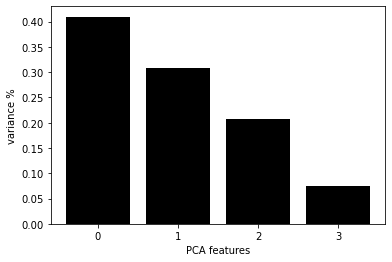

In [15]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

## Building the clustering model using K-Means clustering algorithm

In [16]:
clusters = range(1, 10)
inertias = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:2])
    inertias.append(model.inertia_)



C:\Users\Hariprasad G\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Finding the optimum number of clusters to be used

In order to find the optimum number of clusters, we first plot the inertia value with respect to each cluster. Then, using the elbow method, we find the cluster which has the lowest inertia and thus is the right cluster number to be used

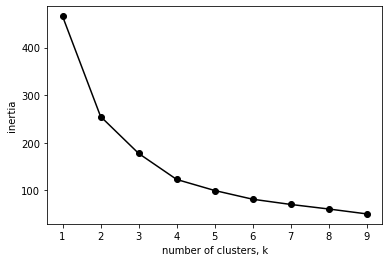

In [18]:
plt.plot(clusters, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(clusters)
plt.show()

Therefore, the optimal number of clusters is 4

### Creating a K-Means model with 4 clusters and finding the sillhoutte score of the trained model

In [19]:
model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:2])

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:2], model.labels_, metric='euclidean')) 


0.4217762265394881


In [20]:
model = KMeans(n_clusters=4)

clusters = model.fit_predict(PCA_components.iloc[:,:2])
newdf["label"] = clusters


### Visualising the clustered data

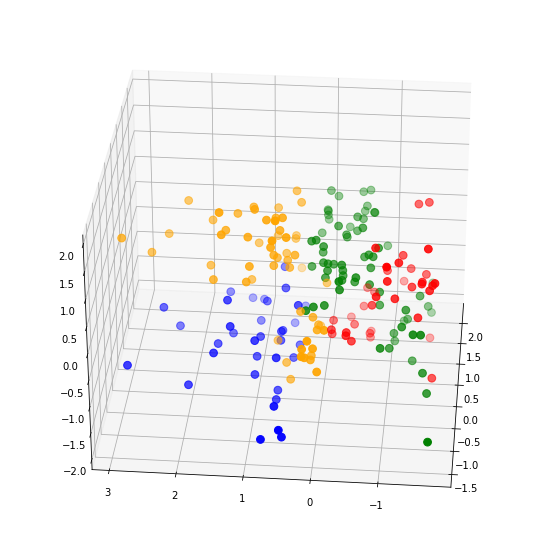

In [21]:


fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newdf.Age[newdf.label == 0], newdf["Annual Income (k$)"][newdf.label == 0], newdf["Spending Score (1-100)"][newdf.label == 0], c='blue', s=60)
ax.scatter(newdf.Age[newdf.label == 1], newdf["Annual Income (k$)"][newdf.label == 1], newdf["Spending Score (1-100)"][newdf.label == 1], c='red', s=60)
ax.scatter(newdf.Age[newdf.label == 2], newdf["Annual Income (k$)"][newdf.label == 2], newdf["Spending Score (1-100)"][newdf.label == 2], c='green', s=60)

ax.scatter(newdf.Age[newdf.label == 3], newdf["Annual Income (k$)"][newdf.label == 3], newdf["Spending Score (1-100)"][newdf.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()



### Analysing the clusters

Let us now map the clusters back to the data set and look at the dataframe

In [22]:
df = pd.read_csv('Mall_Customers.csv')
df = df.drop(['CustomerID'],axis = 1)

In [23]:
pred = model.predict(PCA_components.iloc[:,:2])
frame = pd.DataFrame(df)
frame['cluster'] = pred
frame.head()

Gender  Age  Annual Income (k$)  Spending Score (1-100)  cluster
0    Male   19                  15                      39        1
1    Male   21                  15                      81        1
2  Female   20                  16                       6        2
3  Female   23                  16                      77        1
4  Female   31                  17                      40        1

On taking the average of the features for each cluster, we obtain the following data


In [24]:
avg_df = df.groupby(['cluster'], as_index=False).mean()
display(avg_df)

cluster        Age  Annual Income (k$)  Spending Score (1-100)
0        0  41.685714           88.228571               17.285714
1        1  25.605263           32.631579               67.500000
2        2  52.144928           46.333333               40.072464
3        3  30.000000           79.086207               70.775862

Based on the clusters, we can see that people of different age groups have different average incomes and expenditures